In [2]:
# Libraries
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load private loan PD values from CSV
print("Loading Private_PD.csv...")
private_pd_df = pd.read_csv('Private_PD.csv')
private_PD = private_pd_df['PD'].values
print(f"Loaded {len(private_PD)} PD values for personal loans.\n")

Loading Private_PD.csv...
Loaded 150 PD values for personal loans.



In [3]:
# Fixed parameters
n_assets = 500
n_simulations = 1000
rho = 0.2

# Lending amount (total portfolio)
total_lending_amount = 50000000

# Randomly assigning personal (0) and business (1) loans
loan_types = np.random.choice([0, 1], n_assets, p=[0.7, 0.3])  # assuming 70% personal and 30% business
print(f"Assigned {np.sum(loan_types == 0)} personal loans and {np.sum(loan_types == 1)} business loans.\n")

Assigned 363 personal loans and 137 business loans.



In [4]:
# Adjust PD for personal loans
n_personal_loans = np.sum(loan_types == 0)
n_business_loans = n_assets - n_personal_loans

# Generate random PD for business loans
business_PD = np.random.uniform(0.0001, 0.20, n_business_loans)
print(f"Generated PD values for {n_business_loans} business loans.\n")

print(business_PD)

# Combine PD values
PD = np.zeros(n_assets)
PD[loan_types == 0] = np.random.choice(private_PD, n_personal_loans, replace=True)
PD[loan_types == 1] = business_PD
print("Combined PD values for personal and business loans.\n")

Generated PD values for 137 business loans.

[0.18592044 0.14752093 0.06050546 0.13528278 0.04566353 0.06255875
 0.07529648 0.06848522 0.10203032 0.14073765 0.17437432 0.06677689
 0.19371246 0.07781536 0.0623731  0.19576546 0.00210552 0.01464806
 0.18555122 0.05356446 0.15387511 0.07106089 0.19329488 0.17998024
 0.08641116 0.13705526 0.09690693 0.1213082  0.18763988 0.18405466
 0.14360626 0.03641089 0.11172607 0.08029352 0.11041705 0.15410567
 0.1058884  0.00778442 0.10711508 0.18526672 0.09239361 0.16941645
 0.06743514 0.05990888 0.15400114 0.14427052 0.16140405 0.06501586
 0.1064596  0.08830631 0.17153497 0.17206315 0.16521949 0.06107512
 0.16918883 0.00587429 0.13524212 0.18789657 0.05888252 0.05504609
 0.07124039 0.0179648  0.06354753 0.17302591 0.01186851 0.04239832
 0.04279819 0.06065577 0.14864336 0.03231847 0.13396939 0.07504171
 0.07530276 0.18283508 0.05914268 0.09166496 0.15483934 0.06066662
 0.03271382 0.02118704 0.03595883 0.10280612 0.08261152 0.08871008
 0.13835437 0.009

In [5]:
# Initialize loan amounts and LGD
loan_amounts = np.zeros(n_assets)
LGD = np.zeros(n_assets)

# Assign loan amounts and LGD based on PD and loan type
for i in range(n_assets):
    if loan_types[i] == 0:  # Personal loan
        LGD[i] = 1
        if PD[i] < 0.25:
            loan_amounts[i] = 11500
        else:
            loan_amounts[i] = 0
    else:  # Business loan
        if PD[i] < 0.0001:
            loan_amounts[i] = 600000
            LGD[i] = 0.25
        elif PD[i] < 0.0007:
            loan_amounts[i] = 450000
            LGD[i] = 0.25
        elif PD[i] < 0.0019:
            loan_amounts[i] = 300000
            LGD[i] = 0.4
        elif PD[i] < 0.0536:
            loan_amounts[i] = 100000
            LGD[i] = 0.4
        elif PD[i] < 0.2523:
            loan_amounts[i] = 25000
            LGD[i] = 0.55
        else:
            loan_amounts[i] = 0
            LGD[i] = 0.55
print("Assigned loan amounts and LGD values based on PD and loan type.\n")


Assigned loan amounts and LGD values based on PD and loan type.



In [6]:
# Losses
losses_personal = np.zeros(n_simulations)
losses_business = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X = (np.sqrt(rho**2) * Y[i]) + (np.sqrt(1 - rho**2) * Z[i])
    default_events = X < [norm.ppf(pd) for pd in PD]
    loss_personal = np.sum(default_events[loan_types == 0] * LGD[loan_types == 0] * loan_amounts[loan_types == 0])
    loss_business = np.sum(default_events[loan_types == 1] * LGD[loan_types == 1] * loan_amounts[loan_types == 1])
    losses_personal[i] = loss_personal
    losses_business[i] = loss_business

print("Loss simulation complete.\n")

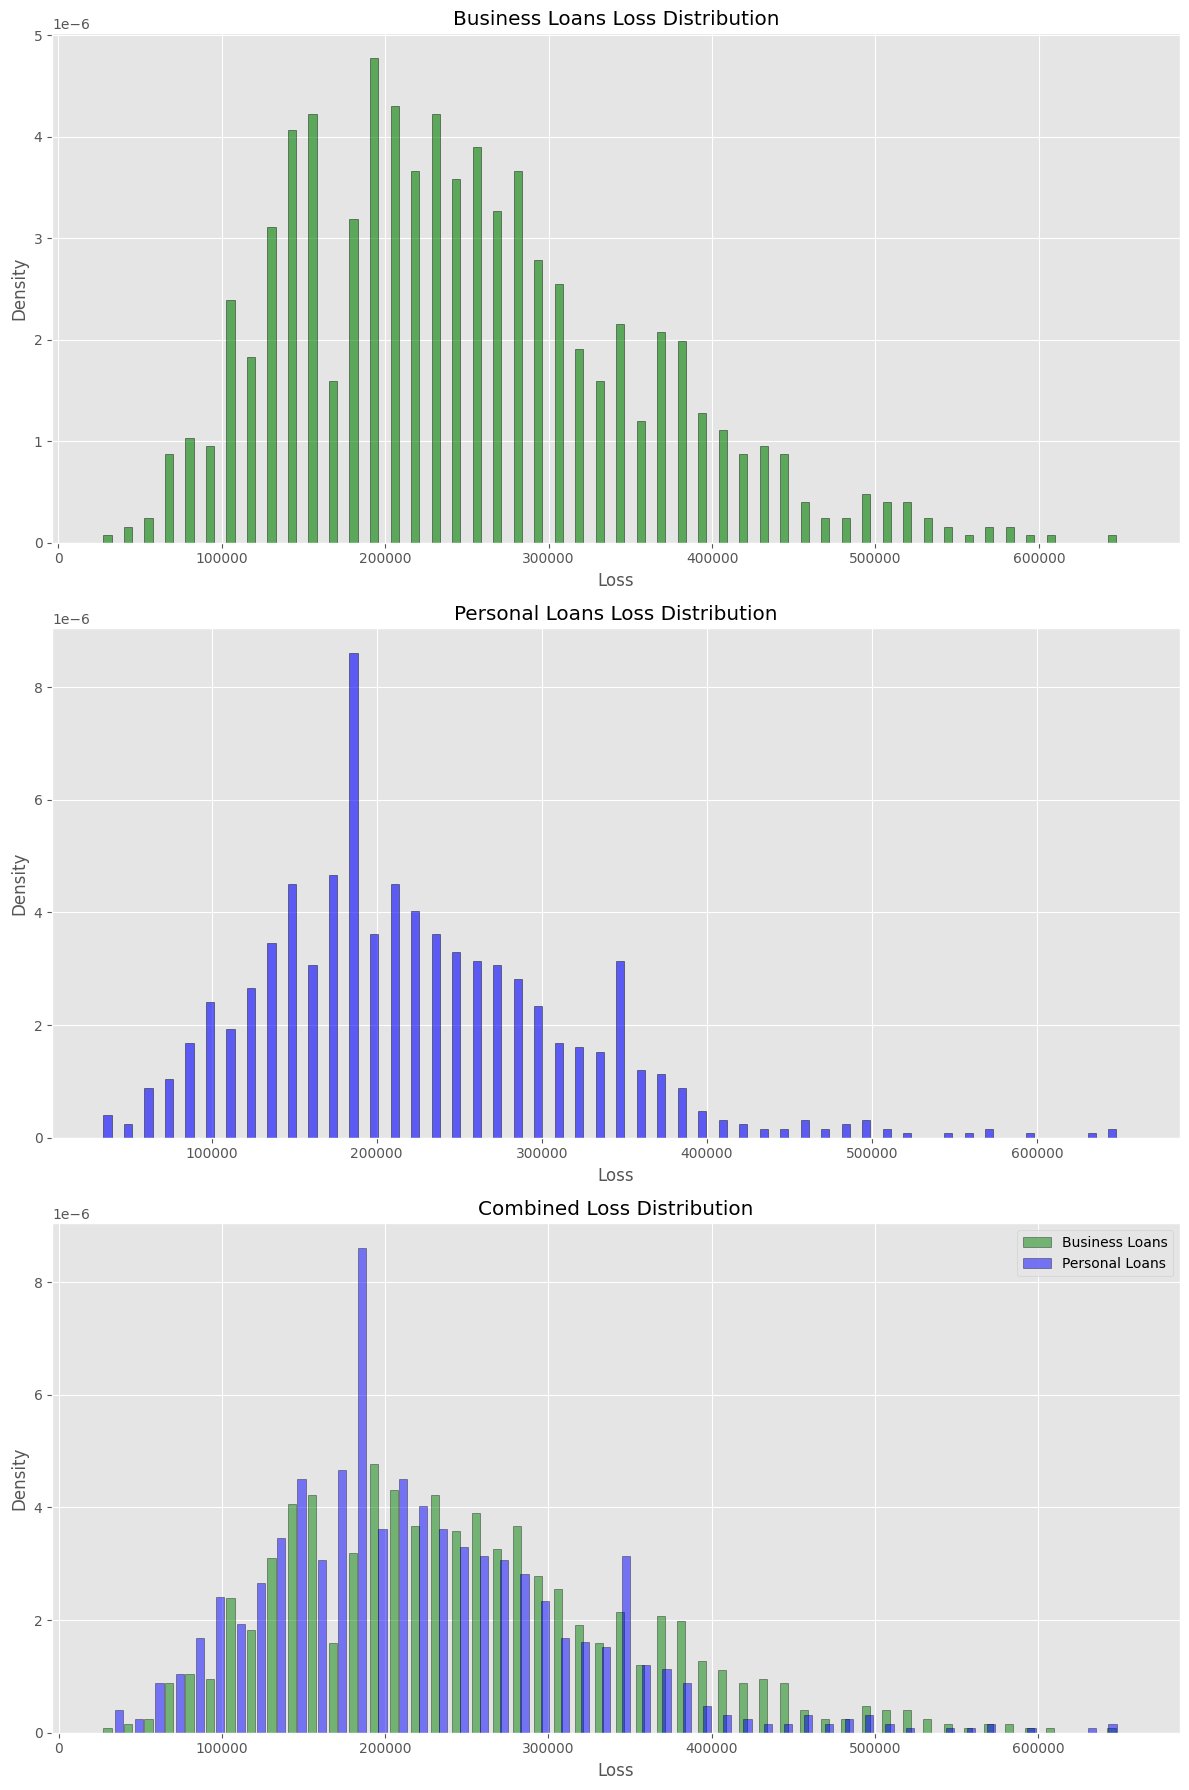

Expected Loss (EL): 478158.50€

Unexpected Loss (UL): 183239.76€

Value at Risk (VaR) 99%: 1063007.50€

Value at Risk (VaR) 95%: 803375.00€



In [ ]:
# Setting the style
plt.style.use('ggplot')

# Creating subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plotting for business loans
axes[0].hist(losses_business, bins=50, density=True, alpha=0.6, color='green', edgecolor='black', linewidth=0.5, width=5000)
axes[0].set_title('Business Loans Loss Distribution')
axes[0].set_xlabel('Loss')
axes[0].set_ylabel('Density')

# Plotting for personal loans
axes[1].hist(losses_personal, bins=50, density=True, alpha=0.6, color='blue', edgecolor='black', linewidth=0.5, width=5000)
axes[1].set_title('Personal Loans Loss Distribution')
axes[1].set_xlabel('Loss')
axes[1].set_ylabel('Density')

# Plotting for combined loans
axes[2].hist(losses_business, bins=50, density=True, alpha=0.5, color='green', label='Business Loans', edgecolor='black', linewidth=0.5, width=5000)
axes[2].hist(losses_personal, bins=50, density=True, alpha=0.5, color='blue', label='Personal Loans', edgecolor='black', linewidth=0.5, width=5000)
axes[2].set_title('Combined Loss Distribution')
axes[2].set_xlabel('Loss')
axes[2].set_ylabel('Density')
axes[2].legend()

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

# Combine losses for calculations
total_losses = losses_personal + losses_business

# Expected Loss (EL)
EL = np.mean(total_losses)
print(f"Expected Loss (EL): {EL:.2f}€\n")

# Unexpected Loss (UL)
UL = np.std(total_losses)
print(f"Unexpected Loss (UL): {UL:.2f}€\n")

# Value at Risk (VaR) 99%
VaR_99 = np.percentile(total_losses, 99)
print(f"Value at Risk (VaR) 99%: {VaR_99:.2f}€\n")

# Value at Risk (VaR) 95%
VaR_95 = np.percentile(total_losses, 95)
print(f"Value at Risk (VaR) 95%: {VaR_95:.2f}€\n")